# ABOUT THIS DOCUMENT



This document is the source code supplement to 'FM405: Building a Quantitative Mortgage Model', and as such is not self-contained. This contains all the codes used to complete the summative assignment, with associated tables and trees in the appendix (since they can be better viewed in the main document). 

_**Please run all cells in order to ensure code cell references match with the main document**_

# SETTING UP THE ENVIRONMENT

In [1]:
import numpy as np
from math import exp,log,sqrt 
from scipy import optimize
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

In [2]:
BE_Curve = np.genfromtxt('yieldcurve.csv', delimiter=',') # importing data
yields = BE_Curve[1,1:22]/100 # Observed Yield Curve for 21 periods
maturity = BE_Curve[0,1:22] # maturities in terms of years
periods = maturity*2 # maturities in terms of 6 month periods # there is a proper function
delta = 0.5 # length of each period, ie half a year
prices = 100*np.exp(-maturity*yields) # prices of ZCBs implied by the yield curve
sigma_HL = 0.0173 # vol for the HL model
sigma_BDT = 0.2142 # vol for the BDT model
theta_HL = np.zeros_like(yields) # vector of calibrated thetas for the HL model (currently zero)
theta_BDT = np.zeros_like(yields) # vector of calibrated thetas for the BDT model (currently zero)
HL_tree = np.zeros((len(yields),len(yields))) # HL tree
BDT_tree = np.zeros((len(yields),len(yields))) # BDT tree

#### Function to price the ZCBs

In [3]:
def pricer(T,model):
    tree = np.zeros((T+1,T+1)) # data structure to hold the tree
    tree[:,T] = 100 # at maturity
    for n in range(T-1,-1,-1): # iterate back from the end of the tree
        for m in range(n+1): # iterate down each column (period)
            if model : # HL tree used 
                tree[m,n] = 0.5*exp(-HL_tree[m,n]*delta)*(tree[m,n+1]+tree[m+1,n+1]) #formula above
            else :     # BDT tree used
                tree[m,n] = 0.5*exp(-BDT_tree[m,n]*delta)*(tree[m,n+1]+tree[m+1,n+1]) #formula above  
    return tree

# PART (a)

### HO-LEE CALIBRATION 

##### Ho-Lee state rates as a function of state and period (assuming $\theta^{HL}$'s have been calibrated)

In [4]:
def r_HL(m,n):
    return yields[0]+delta*sum(theta_HL[0:n])+(n-2*m)*sigma_HL*sqrt(delta)

#### Ho-Lee state rates as a function of calibration target  $\theta^{HL}_{i-2}$, state, and period (at period i, all $\theta^{HL}$s before i-2 have been calibrated)

In [5]:
def r_HL_c(theta_target,m,n): 
    s = delta*theta_target+yields[0]+(n-2*m)*sigma_HL*sqrt(delta)
    if n!= 1:
        s += delta*sum(theta_HL[0:n-1])
    return s

__We do this so that we can used the express the pricing function in terms of the $\theta_{i-1}$ that is the target of our calibration. that is done below. For a T-period ZCB, the calibrator produces the difference between the price implied by the tree and the market observed price. This helps us apply root finding algorithms to calibrate the tree__


In [6]:
def HL_calibrator(theta_target,T): 
    tree = np.zeros((T+1,T+1))       
    tree[:,T] = 100
    for n in range(T-1,-1,-1):
        for m in range(n+1): 
            if n == T-1: 
                tree[m,n] = 0.5*exp(-r_HL_c(theta_target,m,n)*delta)*(tree[m,n+1]+tree[m+1,n+1])
            else:
                tree[m,n] = 0.5*exp(-HL_tree[m,n]*delta)*(tree[m,n+1]+tree[m+1,n+1])

    return tree[0,0]-prices[T-1] 

#### Ho-Lee Tree Calibration Algorithm*

In [7]:
HL_tree[0,0] = yields[0] # root node is observed rate currently
for l in range(2,len(yields)+1): 
    theta_HL[l-2] = optimize.newton(HL_calibrator,0.01,args=[l]) # generating thetas
    for m in range(0,l):
        HL_tree[m,l-1] = r_HL(m,l-1) # generating the tree

### BLACK-DERMAN-TOY CALIBRATION 

#### Black-Derman-Toy state rates as a function of state and period (assuming $\theta^{BDT}$'s  have been calibrated)


In [8]:
def r_BDT(m,n):
    return exp(log(yields[0])+delta*sum(theta_BDT[0:n])+(n-2*m)*sigma_BDT*sqrt(delta))

#### Black-Derman-Toy state rates as a function of calibration target  $\theta^{BDT}_{i-2}$ , state, and period (at period i, all $\theta^{BDT}$s before i-2 have been calibrated)

In [9]:
def r_BDT_c(theta_target,m,n):
    s = delta*theta_target+log(yields[0])+(n-2*m)*sigma_BDT*sqrt(delta)
    if n != 1:
        s += delta*sum(theta_BDT[0:n-1])
    return exp(s)

The idea behind the following steps is the same as the one behind the Ho-Lee tree calibration

In [10]:
def BDT_calibrator(theta_target,T):
    tree = np.zeros((T+1,T+1))
    tree[:,T] = 100
    for n in range(T-1,-1,-1):
        for m in range(n+1): 
            if n == T-1:
                tree[m,n] = 0.5*exp(-r_BDT_c(theta_target,m,n)*delta)*(tree[m,n+1]+tree[m+1,n+1])
            else:
                tree[m,n] = 0.5*exp(-BDT_tree[m,n]*delta)*(tree[m,n+1]+tree[m+1,n+1])

    return tree[0,0]-prices[T-1]

#### Black-Derman-Toy Tree Calibration Algorithm*

In [11]:
BDT_tree[0,0] = yields[0] 
for l in range(2,len(yields)+1):
    theta_BDT[l-2] = optimize.newton(BDT_calibrator,0.01,args=[l])
    for m in range(0,l):
        BDT_tree[m,l-1] = r_BDT(m,l-1)

_*please see the Appendix: Tables and trees for tables constaining the calibrated thetas and trees_



# PART (b)

In [12]:
principal = 100000 # face value of borrowing 

#### Function to find the coupon (or repayment) given $r_M$

In [13]:
def coupon(r,FV,T):
    return ((FV*r*delta)/(1-(1+r*delta)**-T))

#### Function to return the repayment schedule of the mortgage, given the principal, $r_M$, and coupon

In [14]:
# for the matrix, row 1,2, and 3 are interest paid, principal paid ,and outstanding principal respectively 
def os_principal(r,FV,T):
    matrix = np.zeros((3,T+1))
    matrix[2,0] = FV
    for n in range(1,T+1):
        matrix[0,n] = r*delta*matrix[2,n-1]
        matrix[1,n] = coupon(r,principal,len(yields)-1)-matrix[0,n]
        matrix[2,n] = matrix[2,n-1]-matrix[1,n]
    return matrix  

#### Function to return price or value tree of the mortgage assuming no prepayment option

In [15]:
def m_without_p(r,FV,T,model): 
    tree = np.zeros((T+1,T+1)) 
    for n in range(T-1,-1,-1): 
        for m in range(n+1): 
            if model : 
                tree[m,n] = exp(-HL_tree[m,n]*delta)*(0.5*(tree[m,n+1]+tree[m+1,n+1])+coupon(r,FV,T)) 
            else :     
                tree[m,n] = exp(-BDT_tree[m,n]*delta)*(0.5*(tree[m,n+1]+tree[m+1,n+1])+coupon(r,FV,T)) 
    return tree

#### Function to return tree of prepayment option exercise payoff

In [16]:
def p_ex(r,FV,T,model): # value of exercising prepayment
    tree = np.zeros((T+1,T+1))
    for n in range(T-1,-1,-1): 
        for m in range(n+1): 
            tree[m,n] = max(m_without_p(r,FV,T,model)[m,n]-os_principal(r,FV,T)[2,n],0) #positive if value of mortgage is larger than o/s liability
    return tree

#### Function to return value or value tree of prepayment option (accounting for the value of waiting to exercise)

In [17]:
def prepayment_value(r,FV,T,model): # value of prepayment option
    tree = np.zeros((T+1,T+1)) 
    for n in range(T-1,-1,-1): 
        for m in range(n+1): 
            if model: 
                tree[m,n] = max(p_ex(r,FV,T,model)[m,n],exp(-HL_tree[m,n]*delta)*(0.5*(tree[m,n+1]+tree[m+1,n+1]))) #formula above
            else:     
                tree[m,n] = max(p_ex(r,FV,T,model)[m,n],exp(-BDT_tree[m,n]*delta)*(0.5*(tree[m,n+1]+tree[m+1,n+1]))) #formula above  
    return tree

#### Routine to find the fair $r_M$, such that the value of the mortgage with the prepayment of equals the principal

In [18]:
x = lambda r,FV,T,model : m_without_p(r,FV,T,model)[0,0] - prepayment_value(r,FV,T,model)[0,0] - FV

In [19]:
r_M_HL = optimize.newton(x,0.031,args = (principal,len(yields)-1,True),tol = 0.001) #optimisation may take between 1-2 minutes 

In [20]:
r_M_BDT = optimize.newton(x,0.015,args = (principal,len(yields)-1,False),tol = 0.001)

#### The fair rates under both models

In [21]:
pd.DataFrame({"HL":[round(100*r_M_HL,4)],"BDT":[round(100*r_M_BDT,4)]})

,HL,BDT
0,3.1381,1.5266


#### Repayment schedule and the mortgage value tree under both models*

In [22]:
repay_HL = os_principal(r_M_HL,principal,len(yields)-1)
mortgage_value_HL = m_without_p(r_M_HL,principal,len(yields)-1,True)-prepayment_value(r_M_HL,principal,len(yields)-1,True)
repay_BDT = os_principal(r_M_BDT,principal,len(yields)-1) 
repay_BDT[2,20]=0 # since it is not exactly zero due to rounding error
mortgage_value_BDT=m_without_p(r_M_BDT,principal,len(yields)-1,False)-prepayment_value(r_M_BDT,principal,len(yields)-1,False)


_*for tables of these, please see Appendix: Tables and Trees_

# PART (c)

In [23]:
N=100000 

#### Simulating final period rates for both models

In [24]:
HL_realization = np.zeros(N) # 1x100,000 vector to hold rate realisations 
BDT_realization = np.zeros(N) 
for i in range(N): 
    m = sum(np.random.randint(0,2,len(yields)-1)) # 1x20 random vector od 0s and 1s (sequence) 
    HL_realization[i] = HL_tree[m,HL_tree.shape[1]-1] #corresponding rate added to realisation vector
    BDT_realization[i] = BDT_tree[m,BDT_tree.shape[1]-1] 

#### Histogram for Ho-Lee tree

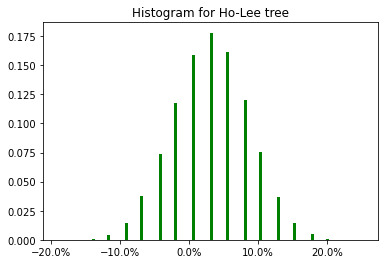

In [25]:
HL_Hist = plt.hist(100*HL_realization,weights = np.ones(len(HL_realization))/len(HL_realization), bins = 100,color='g')
plt.gca().xaxis.set_major_formatter(PercentFormatter())
plt.title("Histogram for Ho-Lee tree")
plt.show()

#### Histogram for Black-Derman-Toy tree


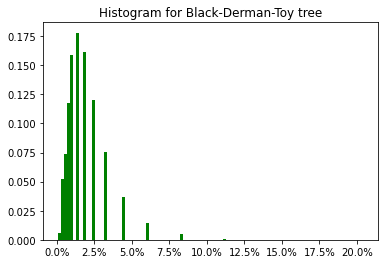

In [26]:
BDT_Hist = plt.hist(100*BDT_realization,weights = np.ones(len(BDT_realization))/len(BDT_realization), bins = 100,color = 'g')
plt.gca().xaxis.set_major_formatter(PercentFormatter())
plt.title("Histogram for Black-Derman-Toy tree")
plt.show()

# PART (d)

#### Setting up the vector of prepayment trigger rates

In [27]:
trigger = np.zeros(BDT_tree.shape[1])
for n in range(1,BDT_tree.shape[1]):
    for m in range(n+1):
        if mortgage_value_BDT[m,n] == os_principal(r_M_BDT,principal,BDT_tree.shape[1]-1)[2,n]: # check for prepayment
            trigger[n] = BDT_tree[m,n] # if prepayment occurs, captures corresponding state rate 
            break

In [28]:
pd.DataFrame(np.around(100*trigger,2),columns = ["Trigger rate at time"]).T

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
Trigger rate at time,0.0,0.89,0.89,1.04,0.88,1.03,0.9,1.05,0.91,1.07,...,1.09,1.27,1.1,1.29,1.12,1.31,1.13,1.33,1.14,0.0


#### Running 100,000 simulations for sample interest rate paths 


In [29]:
rate_path = np.zeros((N,len(yields)))
for m in range(rate_path.shape[0]):
    path = np.random.randint(0,2,20) # generating sequence of zeros and ones
    for n in range(rate_path.shape[1]):
        rate_path[m,n] = BDT_tree[sum(path[0:n]),n] # generating rate path

#### Setting up the discounted cash flow path, given the interest rate path realisation

In [30]:
DCF_path = np.zeros((N,len(yields)))
for m in range(DCF_path.shape[0]):
    for n in range(1,DCF_path.shape[1]): 
        DCF_path[m,n] = exp(-sum(rate_path[m,0:n])*delta)*coupon(r_M_BDT,principal,len(yields)-1) # finds the discounted value of CF occurring in period i of path s
        if rate_path[m,n] <= trigger[n]: # checks for prepayment
            DCF_path[m,n] += exp(-sum(rate_path[m,0:n])*delta)*repay_BDT[2,n] # prepays o/s principal and discounts it
            break      

#### Presenting the results of the simulations for the price of the mortgage

In [31]:
MC_estimate = np.sum(DCF_path,axis=1)
sim_price = np.mean(MC_estimate)
SE = np.std(MC_estimate)/sqrt(N)
Lower = sim_price-1.96*SE
Upper = sim_price+1.96*SE

pd.DataFrame({"Simulations":[N],"Tree Price":[principal],"Price":[np.around(sim_price,2)],"S.E.":[np.around(SE,2)],"Lower (95%)":[np.around(Lower,2)],"Upper (95%)":[np.around(Upper,2)]})

,Simulations,Tree Price,Price,S.E.,Lower (95%),Upper (95%)
0,100000,100000,100002.32,3.48,99995.51,100009.14


# PART (e)

#### Setting up the probability function for the 'random event' prepayment 

In [32]:
def p(i):
    prob = (1-(1-0.5*min(12*i*delta*0.2,6)/100)**delta)
    if i%2 == 0:
        prob *= 2
    return prob

#### Setting up the probability function for _non-optimal_ (lack of) prepayment

In [33]:
def q(r):
    return 0.8*exp(-20*r)

#### Running the 100,000 simulations for the value of the mortgage with prepayment assumptions  

In [34]:
DCF_path_2 = np.zeros((N,len(yields)))
for m in range(DCF_path_2.shape[0]):
    for n in range(1,DCF_path.shape[1]):
        p_test = np.random.random() 
        DCF_path_2[m,n] = exp(-sum(rate_path[m,0:n])*delta)*coupon(r_M_BDT,principal,len(yields)-1)
        if p_test < p(n): # check random prepayment
            DCF_path_2[m,n] += exp(-sum(rate_path[m,0:n])*delta)*repay_BDT[2,n]
            break
        else:
            if rate_path[m,n] <= trigger[n]: 
                q_test = np.random.random() 
                if q_test < q(rate_path[m,n]): #check non-optimal prepayment
                    DCF_path_2[m,n] += exp(-sum(rate_path[m,0:n])*delta)*repay_BDT[2,n]
                    break                                    

#### Presenting Results of the simulations with non-optimal prepayment

In [35]:
MC_estimate_2 = np.sum(DCF_path_2,axis=1)
sim_price_2 = np.mean(MC_estimate_2)
SE_2 = np.std(MC_estimate_2)/sqrt(N)
Lower_2 = sim_price_2-1.96*SE_2
Upper_2 = sim_price_2+1.96*SE_2

pd.DataFrame({"Simulations":[N],"Tree Price":[principal],"Price":[np.around(sim_price_2,2)],"S.E.":[np.around(SE_2,2)],"Lower (95%)":[np.around(Lower_2,2)],"Upper (95%)":[np.around(Upper_2,2)]})


,Simulations,Tree Price,Price,S.E.,Lower (95%),Upper (95%)
0,100000,100000,100155.55,3.34,100148.99,100162.1


_Adjusted par rates given the simulation results_

In [36]:
r_M_BDT_adj = optimize.newton(x,0.015,args = (sim_price_2,len(yields)-1,False),tol = 0.001)
r_M_BDT_l = optimize.newton(x,0.015,args = (Lower_2,len(yields)-1,False),tol = 0.001)
r_M_BDT_u = optimize.newton(x,0.015,args = (Upper_2,len(yields)-1,False),tol = 0.001)
pd.DataFrame({"Adjusted Rate":[round(100*r_M_BDT_adj,4)],"Lower (95%)":[round(100*r_M_BDT_u,4)],"Upper (95%)":[round(100*r_M_BDT_l,4)]})

,Adjusted Rate,Lower (95%),Upper (95%)
0,1.516,1.5155,1.5164


# PART (f)

In [37]:
r_MBS = r_M_BDT-0.005

#### Portion of Repayment schedule available to derivative clients*

In [38]:
repay_MBS =np.zeros_like(repay_BDT)
repay_MBS[1:3,:]=repay_BDT[1:3,:]
for n in range(1,len(yields)):
    repay_MBS[0,n] = r_MBS*delta*repay_MBS[2,n-1]

 _This routine produces an indicator matrix, with 1 in those states and periods when the prepayment option is exercised in the BDT Tree_

In [39]:
exercise_index = np.zeros_like(mortgage_value_BDT)
for n in range(1,(exercise_index.shape[1]-1)):
    for m in range(n+1):
        if mortgage_value_BDT[m,n] == repay_BDT[2,n]:
            exercise_index[m,n] = 1
            break

#### Pricing the Pass-Through, PO, and IO on the BDT tree*

In [40]:
MBS_tree = np.zeros_like(mortgage_value_BDT)
for n in range((MBS_tree.shape[1]-2),-1,-1):
    for m in range(n+1):
        if exercise_index[m,n] == 1:
            MBS_tree[m,n] = repay_MBS[2,n]
        else:
            MBS_tree[m,n] = exp(-BDT_tree[m,n]*delta)*(0.5*(MBS_tree[m,n+1]+MBS_tree[m+1,n+1])+np.sum(repay_MBS[0:2,n+1])) 

            
PO_tree = np.zeros_like(mortgage_value_BDT)
for n in range((PO_tree.shape[1]-2),-1,-1):
    for m in range(n+1):
        if exercise_index[m,n] == 1:
            PO_tree[m,n] = repay_MBS[2,n]
        else:
            PO_tree[m,n] = exp(-BDT_tree[m,n]*delta)*(0.5*(PO_tree[m,n+1]+PO_tree[m+1,n+1])+repay_MBS[1,n+1])
            

IO_tree = MBS_tree-PO_tree            

#### Pricing a Pass-Through, PO, and IO through Monte Carlo (optimal prepayment)

_To match the prepayment instances of the mortgage in part d), we generate an indicator matrix which will indicate where in each path was the prepayment option exercised_

In [41]:
point_of_ex = np.zeros_like(DCF_path)
for m in range(point_of_ex.shape[0]):
    for n in range(point_of_ex.shape[1]-1):
        if DCF_path[m,n+1] == 0:
            point_of_ex[m,n] = 1
            break

In [42]:
PO_path = np.zeros_like(DCF_path)
IO_path = np.zeros_like(DCF_path)
for m in range(point_of_ex.shape[0]):
    for n in range(1,point_of_ex.shape[1]):
        PO_path[m,n] = exp(-sum(rate_path[m,0:n])*delta)*repay_MBS[1,n]
        IO_path[m,n] = exp(-sum(rate_path[m,0:n])*delta)*repay_MBS[0,n]
        if point_of_ex[m,n] == 1:
            PO_path[m,n] += exp(-sum(rate_path[m,0:n])*delta)*repay_MBS[2,n]
            break
            
            
MBS_path = PO_path+IO_path 

In [43]:
tree_prices = np.array([MBS_tree[0,0],PO_tree[0,0],IO_tree[0,0]])
MBS_MC_estimates = np.vstack((np.sum(MBS_path,axis=1),np.sum(PO_path,axis=1),np.sum(IO_path,axis=1)))
MBS_sim_prices = np.mean(MBS_MC_estimates,axis=1)
MBS_SE = np.std(MBS_MC_estimates,axis=1)/sqrt(N)
MBS_Lower = MBS_sim_prices-1.96*MBS_SE
MBS_Upper = MBS_sim_prices+1.96*MBS_SE

In [44]:
first_sim_MBS = pd.DataFrame({"Simulations":[N,N,N],"Tree Price":np.around(tree_prices,2),"Price":np.around(MBS_sim_prices,2),"S.E.":np.around(MBS_SE,2),"Lower (95%)":np.around(MBS_Lower,2),"Upper (95%)":np.around(MBS_Upper,2)}).rename({0:"Pass-Through",1:"PO",2:"IO"})
first_sim_MBS

,Simulations,Tree Price,Price,S.E.,Lower (95%),Upper (95%)
Pass-Through,100000,99030.10,99031.63,5.59,99020.67,99042.58
PO,100000,97038.87,97038.53,10.95,97017.07,97059.99
IO,100000,1991.23,1993.10,5.76,1981.81,2004.38


#### Pricing a Pass-Through, PO, and IO through Monte Carlo (non-optimal prepayment)


_To match the prepayment instances of the mortgage in part e), we generate an indicator matrix which will indicate where in each path was the prepayment option exercised (as done above)_



In [45]:
point_of_ex_2 = np.zeros_like(DCF_path)
for m in range(point_of_ex_2.shape[0]):
    for n in range(point_of_ex_2.shape[1]-1):
        if DCF_path_2[m,n+1] == 0:
            point_of_ex_2[m,n] = 1
            break

In [46]:
PO_path_2 = np.zeros_like(DCF_path)
IO_path_2 = np.zeros_like(DCF_path)
for m in range(point_of_ex_2.shape[0]):
    for n in range(1,point_of_ex_2.shape[1]):
        PO_path_2[m,n] = exp(-sum(rate_path[m,0:n])*delta)*repay_MBS[1,n]
        IO_path_2[m,n] = exp(-sum(rate_path[m,0:n])*delta)*repay_MBS[0,n]
        if point_of_ex_2[m,n] == 1:
            PO_path_2[m,n] += exp(-sum(rate_path[m,0:n])*delta)*repay_MBS[2,n]
            break
            
            
MBS_path_2 = PO_path_2+IO_path_2 

In [47]:
MBS_MC_estimates_2 = np.vstack((np.sum(MBS_path_2,axis=1),np.sum(PO_path_2,axis=1),np.sum(IO_path_2,axis=1)))
MBS_sim_prices_2 = np.mean(MBS_MC_estimates_2,axis=1)
MBS_SE_2 = np.std(MBS_MC_estimates_2,axis=1)/sqrt(N)
MBS_Lower_2 = MBS_sim_prices_2-1.96*MBS_SE_2
MBS_Upper_2 = MBS_sim_prices_2+1.96*MBS_SE_2

In [48]:
second_sim_MBS = pd.DataFrame({"Simulations":[N,N,N],"Tree Price":np.around(tree_prices,2),"Price":np.around(MBS_sim_prices_2,2),"S.E.":np.around(MBS_SE_2,2),"Lower (95%)":np.around(MBS_Lower_2,2),"Upper (95%)":np.around(MBS_Upper_2,2)}).rename({0:"Pass-Through",1:"PO",2:"IO"})
second_sim_MBS

,Simulations,Tree Price,Price,S.E.,Lower (95%),Upper (95%)
Pass-Through,100000,99030.10,99063.36,5.19,99053.18,99073.55
PO,100000,97038.87,96820.81,10.23,96800.76,96840.87
IO,100000,1991.23,2242.55,5.52,2231.73,2253.36



#  APPENDIX: TABLES AND TREES


Please run the following cells to inspect the tables

### Calibrated $\theta s$

In [49]:
pd.concat([pd.DataFrame(np.around(100*theta_HL,3),columns = ["HL"]).T,pd.DataFrame(np.around(100*theta_BDT,3),columns = ["BDT"]).T],axis=0)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
HL,0.249,0.376,0.082,0.05,0.106,0.138,0.153,0.164,0.174,0.187,...,0.218,0.234,0.250,0.264,0.278,0.290,0.302,0.312,0.322,0.0
BDT,22.077,28.794,1.367,-2.37,0.884,2.253,2.188,1.804,1.442,1.318,...,1.395,1.450,1.477,1.459,1.382,1.248,1.061,0.824,0.544,0.0


### Calibrated Ho-Lee Tree

In [50]:
pd.DataFrame(np.around(100*HL_tree,2),columns = list(range(len(yields))))

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.93,2.28,3.69,4.95,6.20,7.48,8.77,10.07,11.38,12.69,...,15.33,16.66,18.00,19.35,20.70,22.07,23.43,24.81,26.19,27.57
1,0.00,-0.17,1.24,2.51,3.76,5.03,6.32,7.62,8.93,10.24,...,12.88,14.21,15.55,16.90,18.26,19.62,20.99,22.36,23.74,25.13
2,0.00,0.00,-1.20,0.06,1.31,2.59,3.88,5.18,6.48,7.79,...,10.43,11.77,13.11,14.46,15.81,17.17,18.54,19.92,21.30,22.68
3,0.00,0.00,0.00,-2.39,-1.14,0.14,1.43,2.73,4.04,5.35,...,7.99,9.32,10.66,12.01,13.36,14.73,16.09,17.47,18.85,20.23
4,0.00,0.00,0.00,0.00,-3.58,-2.31,-1.02,0.28,1.59,2.90,...,5.54,6.87,8.21,9.56,10.92,12.28,13.65,15.02,16.40,17.79
5,0.00,0.00,0.00,0.00,0.00,-4.75,-3.46,-2.16,-0.86,0.45,...,3.09,4.43,5.77,7.12,8.47,9.83,11.20,12.58,13.96,15.34
6,0.00,0.00,0.00,0.00,0.00,0.00,-5.91,-4.61,-3.30,-1.99,...,0.65,1.98,3.32,4.67,6.02,7.39,8.76,10.13,11.51,12.89
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-7.06,-5.75,-4.44,...,-1.80,-0.47,0.87,2.22,3.58,4.94,6.31,7.68,9.06,10.45
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-8.20,-6.89,...,-4.24,-2.91,-1.57,-0.22,1.13,2.49,3.86,5.24,6.62,8.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-9.33,...,-6.69,-5.36,-4.02,-2.67,-1.32,0.05,1.42,2.79,4.17,5.55


### Calibrated Black-Derman-Toy Tree

In [51]:
pd.DataFrame(np.around(100*BDT_tree,2),columns = list(range(len(yields))))

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.93,1.21,1.63,1.90,2.19,2.56,3.01,3.54,4.16,4.87,...,6.69,7.84,9.18,10.76,12.62,14.78,17.31,20.24,23.65,27.59
1,0.00,0.89,1.20,1.41,1.62,1.89,2.22,2.62,3.07,3.60,...,4.94,5.79,6.78,7.95,9.32,10.92,12.78,14.95,17.47,20.38
2,0.00,0.00,0.89,1.04,1.19,1.40,1.64,1.93,2.27,2.66,...,3.65,4.28,5.01,5.87,6.88,8.06,9.44,11.05,12.90,15.06
3,0.00,0.00,0.00,0.77,0.88,1.03,1.21,1.43,1.68,1.96,...,2.70,3.16,3.70,4.34,5.08,5.96,6.97,8.16,9.53,11.12
4,0.00,0.00,0.00,0.00,0.65,0.76,0.90,1.05,1.24,1.45,...,1.99,2.33,2.73,3.20,3.76,4.40,5.15,6.03,7.04,8.21
5,0.00,0.00,0.00,0.00,0.00,0.56,0.66,0.78,0.91,1.07,...,1.47,1.72,2.02,2.37,2.77,3.25,3.81,4.45,5.20,6.07
6,0.00,0.00,0.00,0.00,0.00,0.00,0.49,0.58,0.68,0.79,...,1.09,1.27,1.49,1.75,2.05,2.40,2.81,3.29,3.84,4.48
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.50,0.58,...,0.80,0.94,1.10,1.29,1.51,1.77,2.08,2.43,2.84,3.31
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.37,0.43,...,0.59,0.69,0.81,0.95,1.12,1.31,1.53,1.79,2.10,2.45
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.32,...,0.44,0.51,0.60,0.70,0.83,0.97,1.13,1.33,1.55,1.81


### Repayment Schedule under the Ho-Lee Model


In [52]:
pd.DataFrame(np.around(repay_HL,0),columns = list(range(len(yields)))).rename({0:"Interest paid",1:"Principal Paid",2:"Outstanding Principal"})

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
Interest paid,0.0,1569.0,1502.0,1433.0,1364.0,1293.0,1221.0,1149.0,1075.0,999.0,...,845.0,767.0,687.0,606.0,523.0,439.0,354.0,268.0,180.0,91.0
Principal Paid,0.0,4295.0,4363.0,4431.0,4501.0,4571.0,4643.0,4716.0,4790.0,4865.0,...,5019.0,5098.0,5178.0,5259.0,5341.0,5425.0,5510.0,5597.0,5685.0,5774.0
Outstanding Principal,100000.0,95705.0,91342.0,86911.0,82410.0,77839.0,73196.0,68480.0,63691.0,58826.0,...,48866.0,43768.0,38590.0,33332.0,27990.0,22565.0,17055.0,11458.0,5774.0,0.0


### Mortgage value tree under the Ho-Lee Model (optimal prepayment)

In [53]:
pd.DataFrame(np.around(mortgage_value_HL),columns = list(range(len(yields))))

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,100000.0,93500.0,86165.0,78814.0,71807.0,65328.0,59423.0,54058.0,49159.0,44646.0,...,36473.0,32677.0,28987.0,25342.0,21674.0,17910.0,13969.0,9753.0,5145.0,0.0
1,0.0,95705.0,91249.0,84996.0,78046.0,71082.0,64481.0,58388.0,52811.0,47698.0,...,38546.0,34351.0,30314.0,26364.0,22430.0,18437.0,14302.0,9930.0,5208.0,0.0
2,0.0,0.0,91342.0,86911.0,82363.0,76240.0,69576.0,62989.0,56773.0,51019.0,...,40776.0,36140.0,31720.0,27439.0,23219.0,18982.0,14644.0,10110.0,5272.0,0.0
3,0.0,0.0,0.0,86911.0,82410.0,77839.0,73159.0,67159.0,60781.0,54539.0,...,43173.0,38051.0,33211.0,28570.0,24043.0,19548.0,14996.0,10294.0,5337.0,0.0
4,0.0,0.0,0.0,0.0,82410.0,77839.0,73196.0,68480.0,63655.0,57772.0,...,45705.0,40086.0,34792.0,29761.0,24904.0,20134.0,15358.0,10482.0,5403.0,0.0
5,0.0,0.0,0.0,0.0,0.0,77839.0,73196.0,68480.0,63691.0,58826.0,...,48067.0,42164.0,36453.0,31013.0,25804.0,20741.0,15730.0,10674.0,5469.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,73196.0,68480.0,63691.0,58826.0,...,48866.0,43741.0,38034.0,32298.0,26741.0,21370.0,16113.0,10870.0,5536.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68480.0,63691.0,58826.0,...,48866.0,43768.0,38590.0,33314.0,27654.0,22018.0,16507.0,11070.0,5605.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63691.0,58826.0,...,48866.0,43768.0,38590.0,33332.0,27990.0,22559.0,16901.0,11274.0,5674.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58826.0,...,48866.0,43768.0,38590.0,33332.0,27990.0,22565.0,17055.0,11458.0,5743.0,0.0


### Repayment Schedule under the Black-Derman-Toy Model

In [54]:
pd.DataFrame(np.around(repay_BDT,0),columns = list(range(len(yields)))).rename({0:"Interest paid",1:"Principal Paid",2:"Outstanding Principal"})

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
Interest paid,0.0,763.0,728.0,692.0,656.0,620.0,583.0,546.0,509.0,472.0,...,396.0,358.0,319.0,280.0,241.0,202.0,162.0,122.0,82.0,41.0
Principal Paid,0.0,4647.0,4683.0,4718.0,4754.0,4791.0,4827.0,4864.0,4901.0,4939.0,...,5014.0,5052.0,5091.0,5130.0,5169.0,5209.0,5248.0,5288.0,5329.0,5369.0
Outstanding Principal,100000.0,95353.0,90670.0,85952.0,81198.0,76407.0,71580.0,66716.0,61815.0,56876.0,...,46886.0,41833.0,36742.0,31612.0,26443.0,21235.0,15986.0,10698.0,5369.0,0.0


### Mortgage value tree under the Black-Derman-Toy (optimal prepayment)

In [55]:
pd.DataFrame(np.around(mortgage_value_BDT),columns = list(range(len(yields))))

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,100000.0,94759.0,89290.0,83784.0,78236.0,72683.0,67173.0,61739.0,56399.0,51166.0,...,41058.0,36198.0,31471.0,26873.0,22392.0,18004.0,13664.0,9302.0,4807.0,0.0
1,0.0,95353.0,90558.0,85433.0,80115.0,74691.0,69243.0,63825.0,58465.0,53182.0,...,42887.0,37890.0,32997.0,28205.0,23505.0,18876.0,14285.0,9674.0,4958.0,0.0
2,0.0,0.0,90670.0,85952.0,81137.0,76019.0,70736.0,65390.0,60045.0,54738.0,...,44310.0,39209.0,34187.0,29244.0,24372.0,19555.0,14765.0,9960.0,5072.0,0.0
3,0.0,0.0,0.0,85952.0,81198.0,76407.0,71547.0,66428.0,61184.0,55902.0,...,45400.0,40222.0,35103.0,30044.0,25039.0,20075.0,15133.0,10178.0,5159.0,0.0
4,0.0,0.0,0.0,0.0,81198.0,76407.0,71580.0,66716.0,61802.0,56675.0,...,46215.0,40990.0,35800.0,30653.0,25546.0,20471.0,15411.0,10341.0,5223.0,0.0
5,0.0,0.0,0.0,0.0,0.0,76407.0,71580.0,66716.0,61815.0,56876.0,...,46754.0,41543.0,36320.0,31112.0,25929.0,20769.0,15621.0,10464.0,5272.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,71580.0,66716.0,61815.0,56876.0,...,46886.0,41833.0,36664.0,31445.0,26215.0,20993.0,15778.0,10556.0,5307.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66716.0,61815.0,56876.0,...,46886.0,41833.0,36742.0,31612.0,26405.0,21156.0,15895.0,10625.0,5334.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61815.0,56876.0,...,46886.0,41833.0,36742.0,31612.0,26443.0,21235.0,15974.0,10676.0,5354.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56876.0,...,46886.0,41833.0,36742.0,31612.0,26443.0,21235.0,15986.0,10698.0,5369.0,0.0


### Repayment Schedule for MBS clients

In [56]:
pd.DataFrame(np.around(repay_MBS,0),columns = list(range(len(yields))))

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.0,513.0,489.0,465.0,441.0,417.0,392.0,367.0,342.0,317.0,...,266.0,241.0,215.0,189.0,162.0,136.0,109.0,82.0,55.0,28.0
1,0.0,4647.0,4683.0,4718.0,4754.0,4791.0,4827.0,4864.0,4901.0,4939.0,...,5014.0,5052.0,5091.0,5130.0,5169.0,5209.0,5248.0,5288.0,5329.0,5369.0
2,100000.0,95353.0,90670.0,85952.0,81198.0,76407.0,71580.0,66716.0,61815.0,56876.0,...,46886.0,41833.0,36742.0,31612.0,26443.0,21235.0,15986.0,10698.0,5369.0,0.0


### Pass-Through tree under the Black-Derman-Toy (optimal prepayment)

In [57]:
pd.DataFrame(np.around(MBS_tree),columns = list(range(len(yields))))

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,99030.0,93311.0,87672.0,82172.0,76717.0,71296.0,65936.0,60663.0,55479.0,50391.0,...,40535.0,35782.0,31148.0,26632.0,22220.0,17889.0,13594.0,9267.0,4795.0,0.0
1,0.0,95353.0,89738.0,84236.0,78808.0,73413.0,68053.0,62748.0,57528.0,52386.0,...,42347.0,37459.0,32663.0,27955.0,23326.0,18757.0,14213.0,9638.0,4946.0,0.0
2,0.0,0.0,90670.0,85952.0,80463.0,75068.0,69729.0,64417.0,59134.0,53938.0,...,43757.0,38767.0,33844.0,28987.0,24188.0,19432.0,14691.0,9923.0,5060.0,0.0
3,0.0,0.0,0.0,86572.0,81198.0,76407.0,71021.0,65728.0,60464.0,55168.0,...,44843.0,39773.0,34753.0,29782.0,24851.0,19950.0,15057.0,10140.0,5146.0,0.0
4,0.0,0.0,0.0,0.0,82220.0,76910.0,71580.0,66716.0,61446.0,56267.0,...,45692.0,40544.0,35446.0,30386.0,25355.0,20343.0,15334.0,10303.0,5210.0,0.0
5,0.0,0.0,0.0,0.0,0.0,77653.0,72388.0,67114.0,61815.0,56876.0,...,46451.0,41168.0,35981.0,30845.0,25736.0,20640.0,15543.0,10425.0,5258.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,72916.0,67678.0,62450.0,57237.0,...,46886.0,41833.0,36457.0,31210.0,26025.0,20863.0,15699.0,10517.0,5294.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68049.0,62810.0,57574.0,...,47127.0,41924.0,36742.0,31612.0,26280.0,21035.0,15816.0,10585.0,5321.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63090.0,57847.0,...,47362.0,42123.0,36889.0,31661.0,26443.0,21235.0,15915.0,10636.0,5341.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58055.0,...,47551.0,42295.0,37038.0,31780.0,26519.0,21255.0,15986.0,10698.0,5355.0,0.0


### PO value tree under the Black-Derman-Toy (optimal prepayment)

In [58]:
pd.DataFrame(np.around(PO_tree),columns = list(range(len(yields))))

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,97039.0,90336.0,84350.0,78862.0,73599.0,68448.0,63397.0,58452.0,53588.0,48799.0,...,39462.0,34927.0,30486.0,26137.0,21867.0,17652.0,13452.0,9195.0,4771.0,0.0
1,0.0,95353.0,88054.0,81779.0,76125.0,70790.0,65608.0,60537.0,55603.0,50753.0,...,41239.0,36576.0,31977.0,27441.0,22959.0,18512.0,14065.0,9563.0,4920.0,0.0
2,0.0,0.0,90670.0,85952.0,79079.0,73116.0,67661.0,62420.0,57263.0,52297.0,...,42623.0,37861.0,33140.0,28459.0,23811.0,19180.0,14539.0,9846.0,5034.0,0.0
3,0.0,0.0,0.0,84879.0,81198.0,76407.0,69942.0,64291.0,58987.0,53659.0,...,43699.0,38850.0,34035.0,29243.0,24466.0,19692.0,14902.0,10061.0,5120.0,0.0
4,0.0,0.0,0.0,0.0,79705.0,75471.0,71580.0,66716.0,60715.0,55430.0,...,44620.0,39628.0,34720.0,29839.0,24964.0,20082.0,15177.0,10224.0,5184.0,0.0
5,0.0,0.0,0.0,0.0,0.0,74879.0,70284.0,65875.0,61815.0,56876.0,...,45830.0,40399.0,35284.0,30296.0,25340.0,20376.0,15384.0,10345.0,5232.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,70241.0,65430.0,60646.0,55922.0,...,46886.0,41833.0,36030.0,30728.0,25636.0,20596.0,15539.0,10436.0,5267.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65668.0,60789.0,55904.0,...,46179.0,41397.0,36742.0,31612.0,26022.0,20787.0,15654.0,10504.0,5294.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61024.0,56101.0,...,46196.0,41226.0,36260.0,31320.0,26443.0,21235.0,15793.0,10554.0,5313.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56294.0,...,46348.0,41335.0,36297.0,31236.0,26158.0,21069.0,15986.0,10698.0,5328.0,0.0


### IO tree under the Black-Derman-Toy (optimal prepayment)

In [59]:
pd.DataFrame(np.around(IO_tree),columns = list(range(len(yields))))

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,1991.0,2974.0,3322.0,3310.0,3118.0,2848.0,2540.0,2210.0,1890.0,1591.0,...,1073.0,854.0,662.0,495.0,353.0,236.0,143.0,72.0,24.0,0.0
1,0.0,0.0,1684.0,2457.0,2683.0,2623.0,2444.0,2211.0,1925.0,1634.0,...,1108.0,884.0,686.0,514.0,367.0,245.0,148.0,75.0,25.0,0.0
2,0.0,0.0,0.0,0.0,1385.0,1952.0,2068.0,1997.0,1871.0,1641.0,...,1134.0,906.0,704.0,528.0,377.0,252.0,152.0,77.0,26.0,0.0
3,0.0,0.0,0.0,1692.0,0.0,0.0,1079.0,1437.0,1478.0,1508.0,...,1144.0,922.0,718.0,539.0,385.0,258.0,155.0,78.0,26.0,0.0
4,0.0,0.0,0.0,0.0,2515.0,1439.0,0.0,0.0,732.0,838.0,...,1073.0,916.0,726.0,547.0,391.0,262.0,158.0,79.0,27.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2774.0,2104.0,1239.0,0.0,0.0,...,621.0,770.0,697.0,549.0,396.0,265.0,159.0,80.0,27.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,2675.0,2248.0,1804.0,1315.0,...,0.0,0.0,426.0,482.0,390.0,267.0,161.0,81.0,27.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2381.0,2020.0,1670.0,...,948.0,526.0,0.0,0.0,258.0,249.0,162.0,81.0,27.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2067.0,1746.0,...,1166.0,897.0,628.0,341.0,0.0,0.0,122.0,81.0,27.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1760.0,...,1202.0,960.0,741.0,543.0,362.0,186.0,0.0,0.0,27.0,0.0
